<a href="https://colab.research.google.com/github/darrencheninfo/ADS504_G1_Project/blob/main/evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 0) Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import joblib

sns.set(style="whitegrid", rc={"figure.figsize": (7,5)})

# If using Drive:
from google.colab import drive
drive.mount('/content/drive')

# 1) Load test split + trained pipelines
X_test = pd.read_csv("/content/drive/MyDrive/ADS504 Machine Learning and Deep Learning/X_test.csv")
y_test = pd.read_csv("/content/drive/MyDrive/ADS504 Machine Learning and Deep Learning/y_test.csv").squeeze("columns")

model_paths = {
    "LogReg": "/content/drive/MyDrive/ADS504 Machine Learning and Deep Learning/model_logreg.pkl",
    "RandomForest": "/content/drive/MyDrive/ADS504 Machine Learning and Deep Learning/model_rf.pkl",
    "XGBoost": "/content/drive/MyDrive/ADS504 Machine Learning and Deep Learning/model_xgb.pkl",
}
models = {name: joblib.load(path) for name, path in model_paths.items()}
list(models.keys())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['LogReg', 'RandomForest', 'XGBoost']

In [2]:
# 2) Helper functions
def evaluate_model(name, model, X, y):
    """Return dict of metrics + vectors for plotting."""
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    metrics = {
        "Model": name,
        "ROC_AUC": roc_auc_score(y, y_prob),
        "PR_AUC": average_precision_score(y, y_prob),
        "Accuracy": accuracy_score(y, y_pred),
        "F1": f1_score(y, y_pred),
        "Precision": precision_score(y, y_pred, zero_division=0),
        "Recall": recall_score(y, y_pred, zero_division=0)
    }
    return metrics, y_prob, y_pred

def plot_roc(models, X, y):
    plt.figure(figsize=(7,6))
    for name, model in models.items():
        y_prob = model.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y, y_prob)
        auc = roc_auc_score(y, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1],"k--",lw=1)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (held-out test)"); plt.legend(); plt.show()

def plot_pr(models, X, y):
    plt.figure(figsize=(7,6))
    for name, model in models.items():
        y_prob = model.predict_proba(X)[:, 1]
        prec, rec, _ = precision_recall_curve(y, y_prob)
        ap = average_precision_score(y, y_prob)
        plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision–Recall Curves (held-out test)"); plt.legend(); plt.show()


In [3]:
# 3) Evaluate & compare
rows = []
vectors = {}

for name, model in models.items():
    metrics, y_prob, y_pred = evaluate_model(name, model, X_test, y_test)
    rows.append(metrics)
    vectors[name] = {"prob": y_prob, "pred": y_pred}

summary = pd.DataFrame(rows).sort_values("ROC_AUC", ascending=False)
summary


,Model,ROC_AUC,PR_AUC,Accuracy,F1,Precision,Recall
0,LogReg,0.764901,0.914267,0.663179,0.740200,0.904225,0.626545
2,XGBoost,0.764054,0.911136,0.704285,0.786703,0.878764,0.712101
1,RandomForest,0.756284,0.906087,0.783259,0.870304,0.803247,0.949577


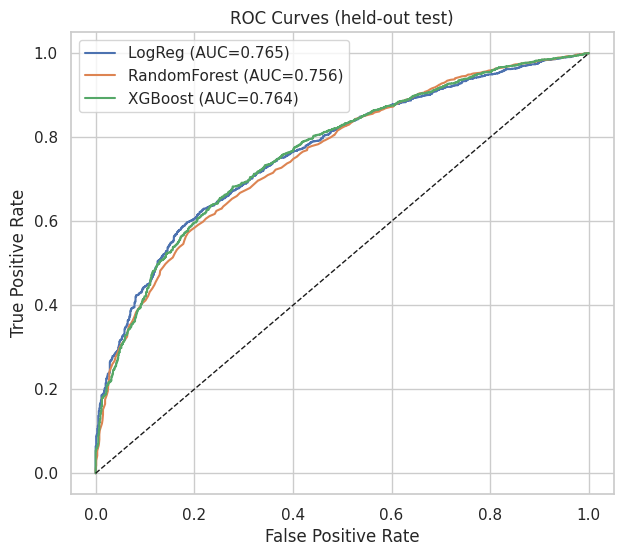

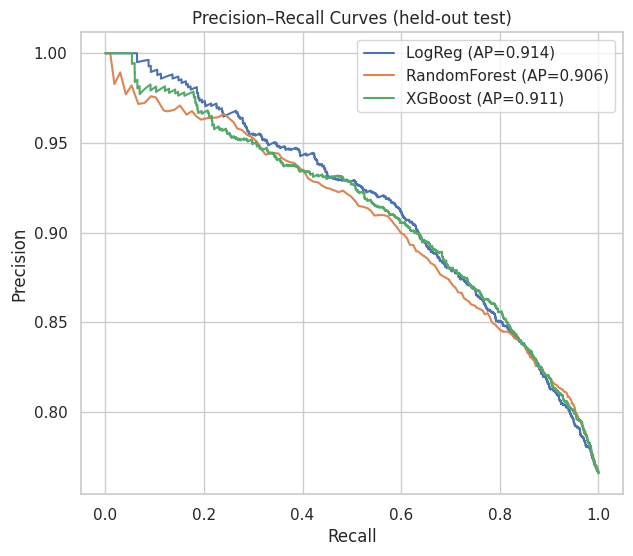

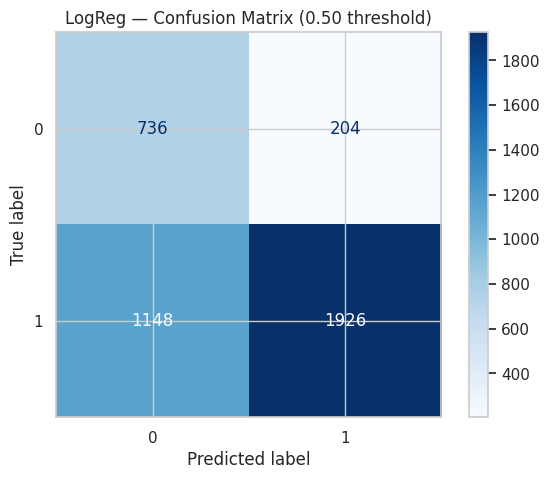

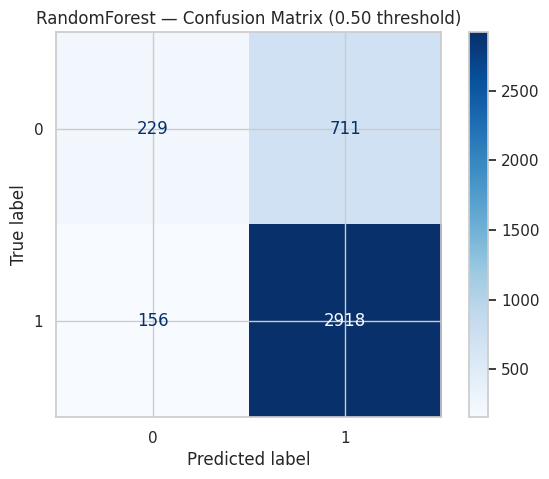

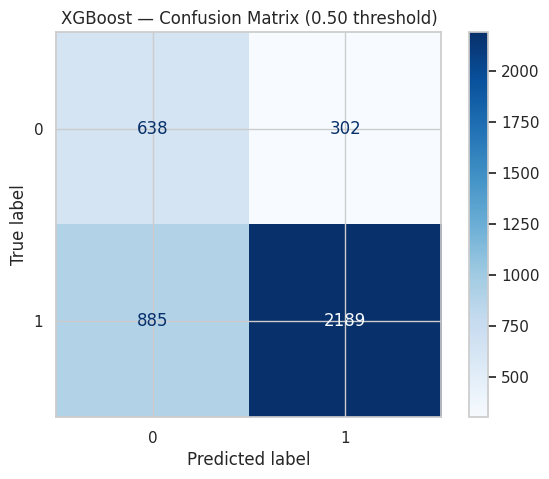

In [4]:
# 4) Plots: ROC, PR, Confusion Matrices
plot_roc(models, X_test, y_test)
plot_pr(models, X_test, y_test)

for name, model in models.items():
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Blues")
    disp.ax_.set_title(f"{name} — Confusion Matrix (0.50 threshold)")
    plt.show()


,threshold,Precision,Recall,F1,Accuracy
0,0.050000,0.766201,1.000000,0.867626,0.766318
1,0.100000,0.767000,0.998048,0.867402,0.766318
2,0.150000,0.772117,0.990891,0.867930,0.769058
3,0.200000,0.785357,0.970072,0.867996,0.774041
4,0.250000,0.800721,0.939818,0.864711,0.774788
5,0.300000,0.819349,0.892648,0.854429,0.767065
6,0.350000,0.842018,0.830514,0.836227,0.750872
7,0.400000,0.860635,0.767404,0.811350,0.726707
8,0.450000,0.880363,0.694209,0.776282,0.693572
9,0.500000,0.904225,0.626545,0.740200,0.663179


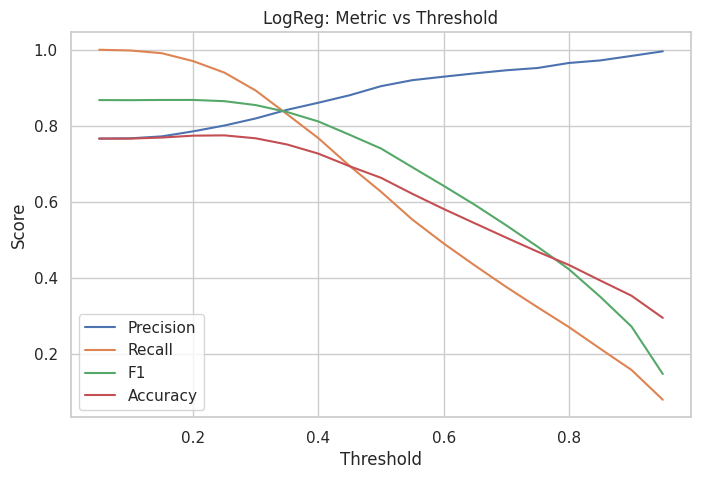

np.float64(0.5212422383359895)

In [5]:
# 5) Threshold analysis (choose operating point)
#    Show how metrics move vs threshold for the best model by ROC_AUC
best_name = summary.iloc[0]["Model"]
best_model = models[best_name]
y_prob = vectors[best_name]["prob"]

thresholds = np.linspace(0.05, 0.95, 19)
records = []
for t in thresholds:
    y_hat = (y_prob >= t).astype(int)
    records.append({
        "threshold": t,
        "Precision": precision_score(y_test, y_hat, zero_division=0),
        "Recall": recall_score(y_test, y_hat, zero_division=0),
        "F1": f1_score(y_test, y_hat),
        "Accuracy": accuracy_score(y_test, y_hat)
    })
thr_df = pd.DataFrame(records)

display(thr_df.style.background_gradient(cmap="Blues"))

plt.figure(figsize=(8,5))
plt.plot(thresholds, thr_df["Precision"], label="Precision")
plt.plot(thresholds, thr_df["Recall"], label="Recall")
plt.plot(thresholds, thr_df["F1"], label="F1")
plt.plot(thresholds, thr_df["Accuracy"], label="Accuracy")
plt.xlabel("Threshold"); plt.ylabel("Score")
plt.title(f"{best_name}: Metric vs Threshold")
plt.legend(); plt.show()

# Youden's J (on ROC) to pick a point maximizing (TPR - FPR)
fpr, tpr, roc_th = roc_curve(y_test, y_prob)
youden_idx = np.argmax(tpr - fpr)
youden_thr = roc_th[youden_idx]
youden_thr


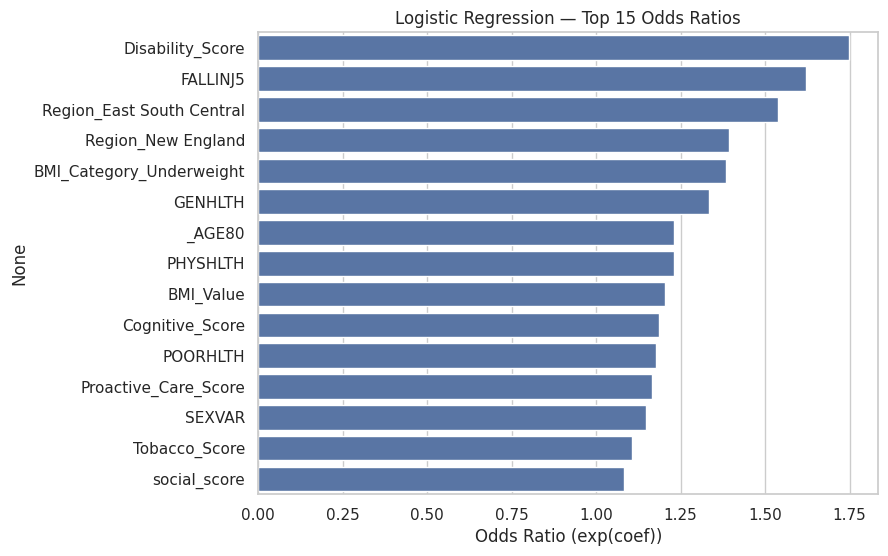

In [6]:
# 6) Interpretability — Logistic Regression odds ratios (top 15)
import numpy as np

lr_pipe = models.get("LogReg")
if lr_pipe is not None:
    prep = lr_pipe.named_steps["prep"]
    clf = lr_pipe.named_steps["clf"]

    # Recover original column lists from the fitted ColumnTransformer
    num_cols = prep.transformers_[0][2]
    cat_cols = prep.transformers_[1][2]
    oh = prep.transformers_[1][1].named_steps["onehot"]
    oh_names = oh.get_feature_names_out(cat_cols).tolist()
    feat_names = list(num_cols) + oh_names

    odds_ratios = pd.Series(np.exp(clf.coef_[0]), index=feat_names).sort_values(ascending=False)
    top = odds_ratios.head(15)

    plt.figure(figsize=(8,6))
    sns.barplot(x=top.values, y=top.index, orient="h")
    plt.xlabel("Odds Ratio (exp(coef))")
    plt.title("Logistic Regression — Top 15 Odds Ratios")
    plt.show()


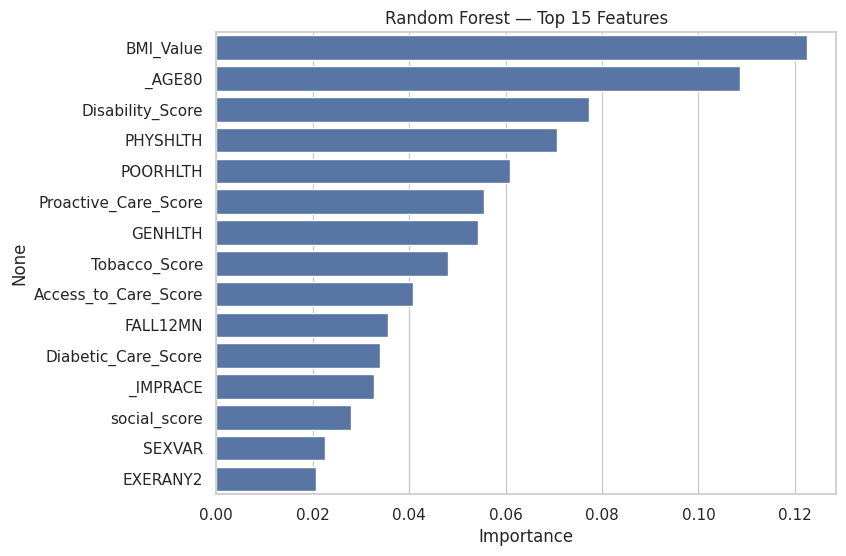

In [7]:
# 7) Interpretability — Random Forest importances (top 15)
rf_pipe = models.get("RandomForest")
if rf_pipe is not None:
    prep = rf_pipe.named_steps["prep"]
    clf = rf_pipe.named_steps["clf"]
    num_cols = prep.transformers_[0][2]
    cat_cols = prep.transformers_[1][2]
    oh = prep.transformers_[1][1].named_steps["onehot"]
    oh_names = oh.get_feature_names_out(cat_cols).tolist()
    feat_names = list(num_cols) + oh_names

    rf_imp = pd.Series(clf.feature_importances_, index=feat_names).sort_values(ascending=False).head(15)
    plt.figure(figsize=(8,6))
    sns.barplot(x=rf_imp.values, y=rf_imp.index, orient="h")
    plt.xlabel("Importance")
    plt.title("Random Forest — Top 15 Features")
    plt.show()


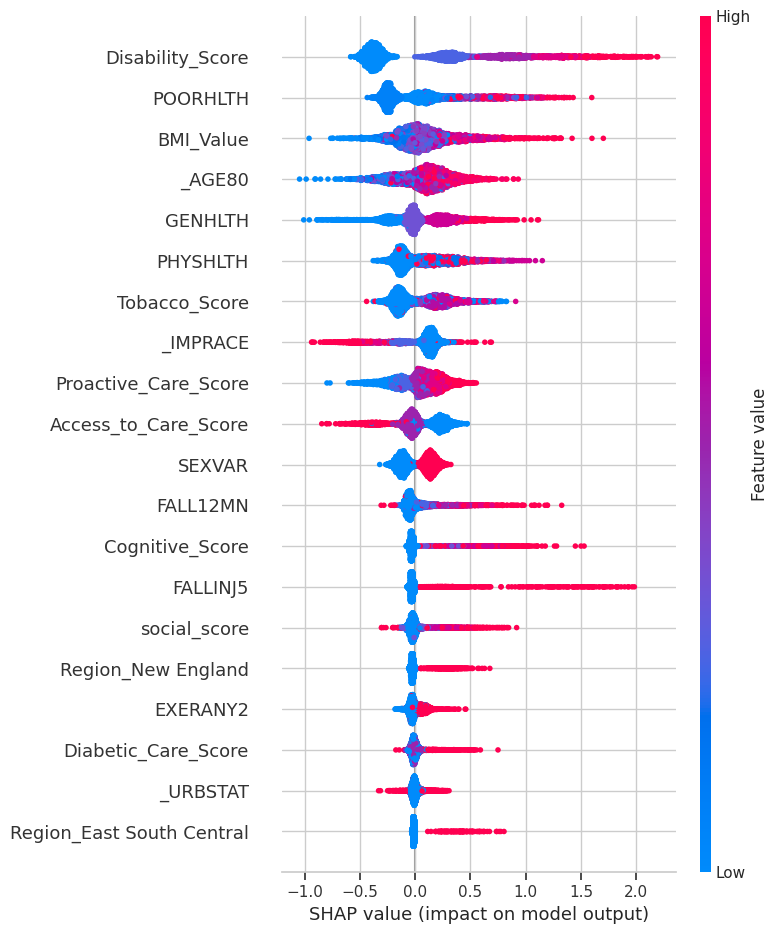

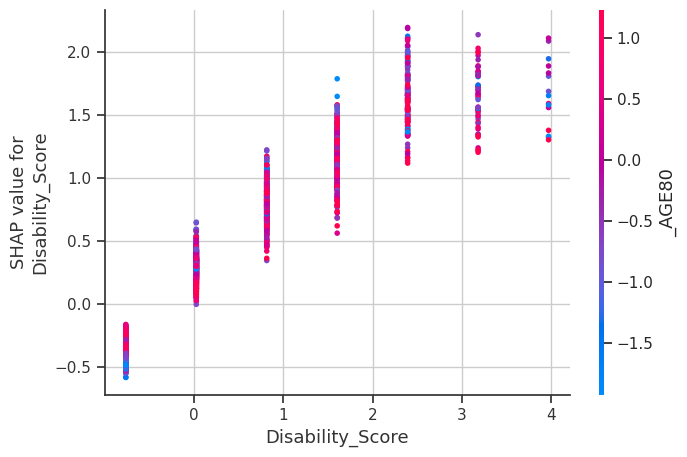

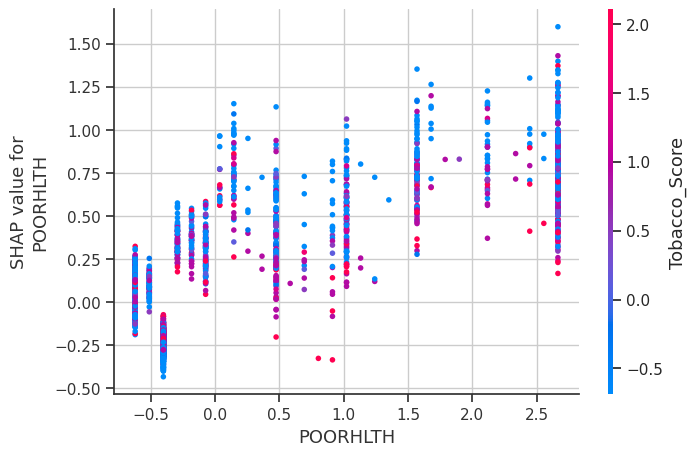

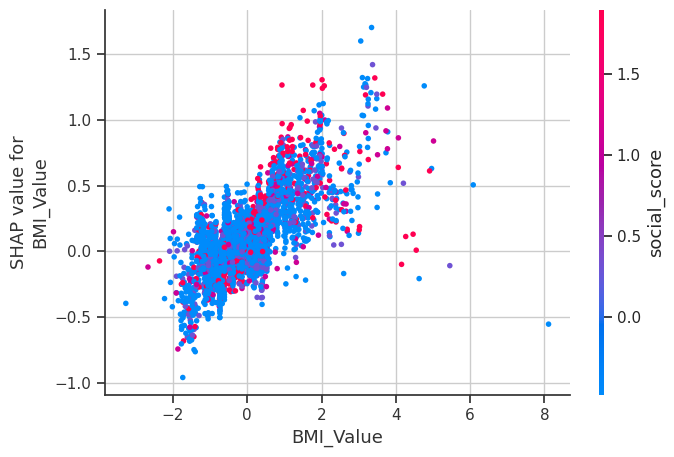

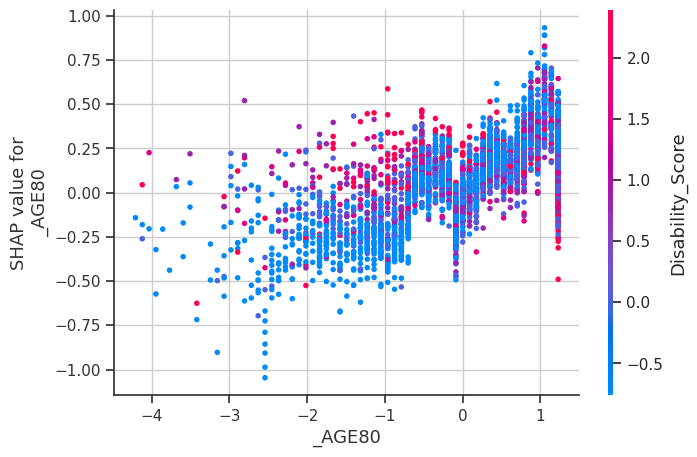

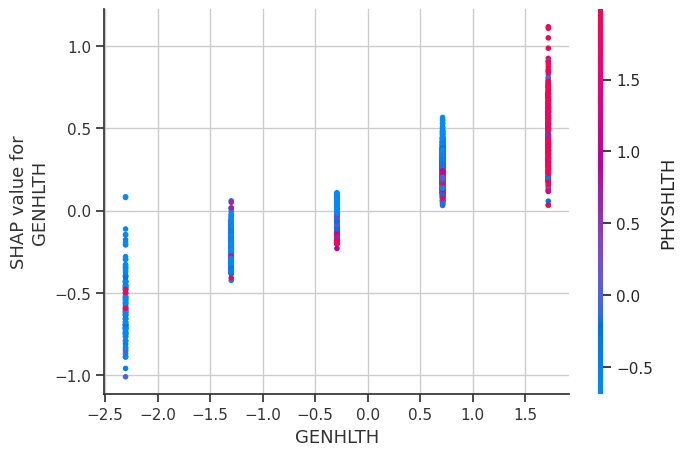

In [8]:
# 8) Interpretability — XGBoost SHAP (global + dependence)
try:
    import shap
    xgb_pipe = models.get("XGBoost")
    if xgb_pipe is not None:
        prep = xgb_pipe.named_steps["prep"]
        xgb = xgb_pipe.named_steps["clf"]

        # Transform test data to model space; get feature names
        num_cols = prep.transformers_[0][2]
        cat_cols = prep.transformers_[1][2]
        oh = prep.transformers_[1][1].named_steps["onehot"]
        oh_names = oh.get_feature_names_out(cat_cols).tolist()
        feat_names = list(num_cols) + oh_names

        X_test_tx = prep.transform(X_test)
        explainer = shap.TreeExplainer(xgb)
        shap_values = explainer(X_test_tx)

        shap.summary_plot(shap_values, X_test_tx, feature_names=feat_names, show=True)

        # Optional: dependence plot for top features
        abs_mean = np.abs(shap_values.values).mean(axis=0)
        top_idx = abs_mean.argsort()[::-1][:5]
        for i in top_idx:
            shap.dependence_plot(i, shap_values.values, X_test_tx, feature_names=feat_names, show=True)
except Exception as e:
    print("SHAP skipped (install/compat issue):", e)


In [9]:
# 9) Final tidy summary table
display(summary.style.format({
    "ROC_AUC": "{:.3f}", "PR_AUC": "{:.3f}", "Accuracy": "{:.3f}",
    "F1": "{:.3f}", "Precision": "{:.3f}", "Recall": "{:.3f}"
}).background_gradient(cmap="Greens"))


,Model,ROC_AUC,PR_AUC,Accuracy,F1,Precision,Recall
0,LogReg,0.765,0.914,0.663,0.740,0.904,0.627
2,XGBoost,0.764,0.911,0.704,0.787,0.879,0.712
1,RandomForest,0.756,0.906,0.783,0.870,0.803,0.950
